In [1]:
import random
import time
from itertools import combinations
import matplotlib.pyplot as plt
import gurobipy as gp
import pandas as pd
import numpy as np
from gurobipy import GRB


random.seed(10000)


## Creating the data

In [2]:
n = 10

def random_points(n):
    points ={}
    for i in range(n):
        points[i] = (random.randint(0, 100), random.randint(0, 100))
    return(points)


points = random_points(n)
print(points)


{0: (73, 97), 1: (38, 4), 2: (88, 15), 3: (90, 3), 4: (83, 98), 5: (80, 0), 6: (33, 64), 7: (41, 22), 8: (13, 86), 9: (72, 48)}


In [3]:
points[0][1]

97

In [4]:
A_costs = {(i, j):random.randint(0, 10)
for i in range(n) for j in range(n) if i!=j}
print(A_costs)
print(A_costs[0,1])

V_profits = {i:
             random.randint(1, 10)
             for i in range(n)}
print(V_profits)
print(V_profits[0])
profit = [V_profits[i] for i,_ in enumerate(V_profits)]
print(profit)


{(0, 1): 0, (0, 2): 4, (0, 3): 0, (0, 4): 9, (0, 5): 3, (0, 6): 0, (0, 7): 5, (0, 8): 9, (0, 9): 9, (1, 0): 4, (1, 2): 8, (1, 3): 8, (1, 4): 2, (1, 5): 1, (1, 6): 10, (1, 7): 1, (1, 8): 5, (1, 9): 0, (2, 0): 6, (2, 1): 10, (2, 3): 2, (2, 4): 0, (2, 5): 5, (2, 6): 7, (2, 7): 6, (2, 8): 4, (2, 9): 5, (3, 0): 6, (3, 1): 8, (3, 2): 7, (3, 4): 9, (3, 5): 10, (3, 6): 10, (3, 7): 5, (3, 8): 8, (3, 9): 2, (4, 0): 1, (4, 1): 4, (4, 2): 7, (4, 3): 8, (4, 5): 8, (4, 6): 9, (4, 7): 10, (4, 8): 6, (4, 9): 1, (5, 0): 6, (5, 1): 3, (5, 2): 7, (5, 3): 1, (5, 4): 3, (5, 6): 2, (5, 7): 7, (5, 8): 9, (5, 9): 8, (6, 0): 9, (6, 1): 0, (6, 2): 9, (6, 3): 5, (6, 4): 10, (6, 5): 8, (6, 7): 0, (6, 8): 9, (6, 9): 9, (7, 0): 0, (7, 1): 8, (7, 2): 2, (7, 3): 6, (7, 4): 6, (7, 5): 7, (7, 6): 2, (7, 8): 5, (7, 9): 6, (8, 0): 7, (8, 1): 9, (8, 2): 10, (8, 3): 3, (8, 4): 8, (8, 5): 5, (8, 6): 8, (8, 7): 3, (8, 9): 10, (9, 0): 5, (9, 1): 3, (9, 2): 0, (9, 3): 10, (9, 4): 1, (9, 5): 3, (9, 6): 2, (9, 7): 0, (9, 8): 6}


### Showing the graph

In [5]:

def plot_dgraph(points, profits, archs, title="Graph", figsize=(12, 12), save_fig=None, show_vars=None, color = 'b'):
    """
    Plot a directed graph

    :param points: list of points.
    :param profits: list of point profits
    :param archs: list of selected archs
    :param title: title of the figure.
    :param figsize: width and height of the figure
    :param save_fig: if provided, path to file in which the figure will be save.
    :param show_vars: if provided, shows the cost and profits in the graph.
    :param color: color of graph, default is b = blue
    :return: None
    """

    plt.figure(figsize=figsize)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title, fontsize=15)
    plt.grid()
    x = [points[i][0] for i, _ in enumerate(points)]
    y = [points[i][1] for i, _ in enumerate(points)]
    profit = [profits[i]*100 for i,_ in enumerate(profits)]
    plt.scatter(x, y, s=profit)

    n = len(points)

    # Add label to points and profits
    for i, label in enumerate(points):
        plt.annotate('{}'.format(i), (x[i]+0.2, y[i]+0.2), size=23)
        if show_vars:
            plt.annotate(f"p:{profits[i]}", (x[i], y[i]+1), size=20, color='red')
    

    for (i, j) in archs:
        plt.arrow(x[i], y[i], x[j]-x[i], y[j]-y[i], fc=color,
                  ec=color, head_width=1, head_length=1,length_includes_head=True)
        if show_vars:
            if i>j:
                plt.annotate(f"c:{archs[i,j]}", ((x[i]+x[j])/2 +1 , (y[i]+y[j])/2 +2), size=15, color='black')
            else:
                plt.annotate(f"c:{archs[i,j]}", ((x[i]+x[j])/2 -1,
                            (y[i]+y[j])/2 - 2), size=15, color='black')

    if save_fig:
        plt.savefig(save_fig)
    else:
       plt.show()


def plot_tour(points, tour, title="Tour", figsize=(12, 12), save_fig=None):
    """
    Plot a tour.

    :param points: list of points.
    :param tour: list of indexes that describes in which order the points are
                 visited.
    :param title: title of the figure.
    :param figsize: width and height of the figure
    :param save_fig: if provided, path to file in which the figure will be save.
    :return: None
    """
    x = [points[i][0] for i in points.keys()]
    y = [points[i][1] for i in points.keys()]

    plt.figure(figsize=figsize)
    plt.scatter(x, y, s=60)
    n = len(points)

    # Add label to points
    for i, label in enumerate(points):
        plt.annotate('{}'.format(i), (x[i]+0.1, y[i]+0.1), size=25)

   # Add the arcs
    for i in range(n):
        for j in range(n):
            if j < i:
                plt.plot([points[i][0], points[j][0]], [
                         points[i][1], points[j][1]], 'b', alpha=.01)
    for (i, j) in zip(tour[:], tour[1:] + tour[:1]):
        plt.annotate("", xy=points[j], xytext=points[i],
                     arrowprops=dict(facecolor='black', width=1))
        plt.plot([points[i][0], points[j][0]], [
                 points[i][1], points[j][1]], 'r', alpha=1.)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title, fontsize=15)
    plt.grid()

    if save_fig:
        plt.savefig(save_fig)
    else:
        plt.show()



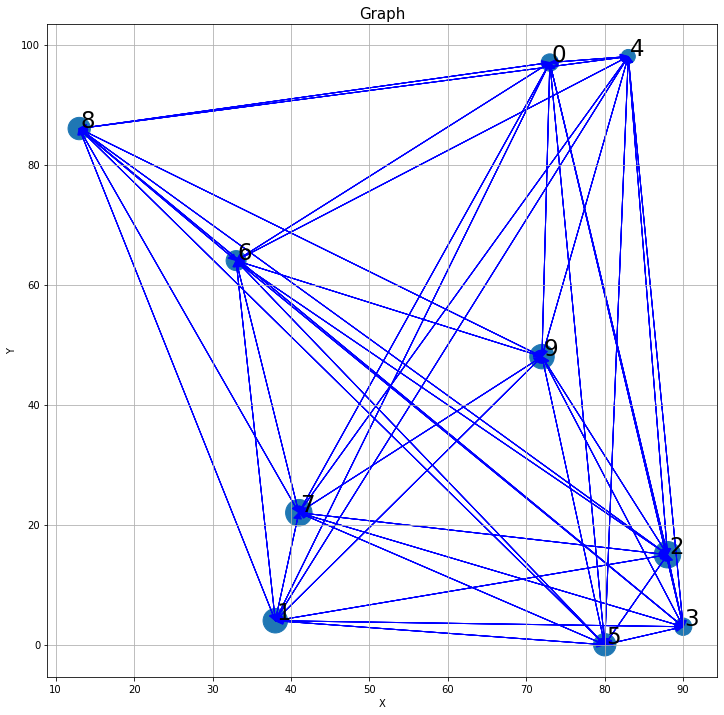

In [6]:
plot_dgraph(points,V_profits, A_costs, show_vars=False)

points:{0: (78, 54), 1: (26, 100), 2: (47, 9)}
profits:{0: 5, 1: 9, 2: 10}
costs:{(0, 1): 2, (1, 2): 3, (2, 0): 1}


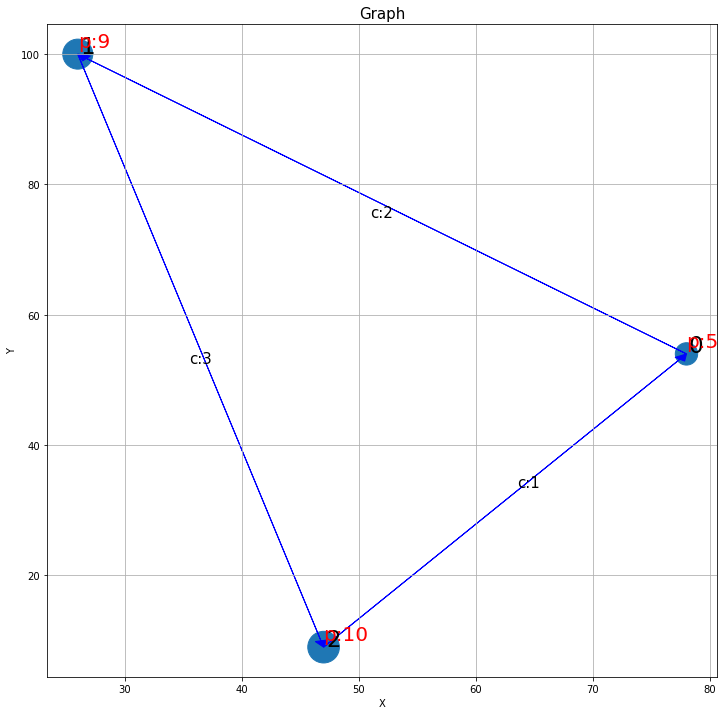

In [7]:
#toy example of an oriented graph

ex_points = random_points(3)
print("points:" + str(ex_points))

ex_profits ={i:
random.randint(1, 10)
for i in range(len(ex_points))
}
print("profits:"+str(ex_profits))

ex_costs = {(0,1): 2, (1,2): 3, (2,0): 1}
print("costs:"+str(ex_costs))

plot_dgraph(ex_points,ex_profits, ex_costs, show_vars=True)


### Saving and Loading the data in a CSV

In [8]:
df_points = pd.DataFrame.from_dict(
    ex_points,orient='index', columns=["x_cor","y_cor"])
df_points


,x_cor,y_cor
0,78,54
1,26,100
2,47,9


In [9]:
df_profits = pd.DataFrame.from_dict(ex_profits, orient='index', columns=['vertex_profits'])
df_profits

,vertex_profits
0,5
1,9
2,10


In [10]:
df_costs = pd.DataFrame.from_dict(ex_costs, orient='index', columns=["arch_costs"])
df_costs

,arch_costs
"(0, 1)",2
"(1, 2)",3
"(2, 0)",1


In [11]:
ex_vertex_graph =pd.concat([df_points,df_profits], axis=1)
ex_vertex_graph

,x_cor,y_cor,vertex_profits
0,78,54,5
1,26,100,9
2,47,9,10


In [12]:
def save_graph_csv(points, v_profits, a_costs, graphname = "graph"):
    #saving points and profits
    df_points = pd.DataFrame.from_dict(
        points, orient='index', columns=["x_cor", "y_cor"])
    df_profits = pd.DataFrame.from_dict(
        v_profits, orient='index', columns=['vertex_profits'])
    df_vertexs = pd.concat([df_points, df_profits], axis=1)
    df_vertexs.to_csv(f"{graphname}_points_profits.csv", index=True)

    #saving arch costs
    df_costs = pd.DataFrame.from_dict(
        a_costs, orient='index', columns=["arch_costs"])
    df_costs.to_csv(f"{graphname}_arch_costs.csv", index=True)

    print("Saved the following data:\n")
    print(df_vertexs)
    print(df_costs)    


In [13]:
save_graph_csv(ex_points,ex_profits,ex_costs, graphname="example_graph")

Saved the following data:

   x_cor  y_cor  vertex_profits
0     78     54               5
1     26    100               9
2     47      9              10
        arch_costs
(0, 1)           2
(1, 2)           3
(2, 0)           1


In [14]:
df_file_points = pd.read_csv("example_graph_points_profits.csv", index_col=0)
df_file_points

,x_cor,y_cor,vertex_profits
0,78,54,5
1,26,100,9
2,47,9,10


In [15]:
df_file_costs = pd.read_csv("example_graph_arch_costs.csv", index_col=0)
df_file_costs

,arch_costs
"(0, 1)",2
"(1, 2)",3
"(2, 0)",1


In [16]:
loaded_points = df_file_points.to_dict(orient='index')
print(loaded_points)
points = {}
profits = {}
for i, j in enumerate(loaded_points):
    points[i] = (loaded_points[i]["x_cor"], loaded_points[i]["y_cor"])
    profits[i] = (loaded_points[i]["vertex_profits"])
print(points)
print(profits)


{0: {'x_cor': 78, 'y_cor': 54, 'vertex_profits': 5}, 1: {'x_cor': 26, 'y_cor': 100, 'vertex_profits': 9}, 2: {'x_cor': 47, 'y_cor': 9, 'vertex_profits': 10}}
{0: (78, 54), 1: (26, 100), 2: (47, 9)}
{0: 5, 1: 9, 2: 10}


In [17]:
loaded_costs = df_file_costs.to_dict()
print(loaded_costs["arch_costs"])
costs = {}
for key, value in enumerate(loaded_costs["arch_costs"]):
    costs[tuple(eval(value))] = loaded_costs["arch_costs"][value]

print(costs)


{'(0, 1)': 2, '(1, 2)': 3, '(2, 0)': 1}
{(0, 1): 2, (1, 2): 3, (2, 0): 1}


In [18]:
def load_graph_csv(points_file = "", arch_file = ""):
    #read the csv files
    if not(len(points_file)>0 and len(arch_file)>0):
        print("need to specify filepaths")
        return None, None, None
    df_file_points = pd.read_csv(
        points_file, index_col=0)
    df_file_costs = pd.read_csv(arch_file, index_col=0)

    #create the vertex and vertex profit dictionaries
    loaded_points = df_file_points.to_dict(orient='index')
    points = {}
    profits = {}
    for i, _ in enumerate(loaded_points):
        points[i] = (loaded_points[i]["x_cor"], loaded_points[i]["y_cor"])
        profits[i] = (loaded_points[i]["vertex_profits"])
    
    loaded_costs = df_file_costs.to_dict()
    costs = {}
    for key, value in enumerate(loaded_costs["arch_costs"]):
        costs[tuple(eval(value))] = loaded_costs["arch_costs"][value]
    
    print("loaded the following data:\n")
    print(f"Points: {points}\nProfits: {profits}\nCosts: {costs}")
    
    return points, profits, costs



loaded the following data:

Points: {0: (78, 54), 1: (26, 100), 2: (47, 9)}
Profits: {0: 5, 1: 9, 2: 10}
Costs: {(0, 1): 2, (1, 2): 3, (2, 0): 1}


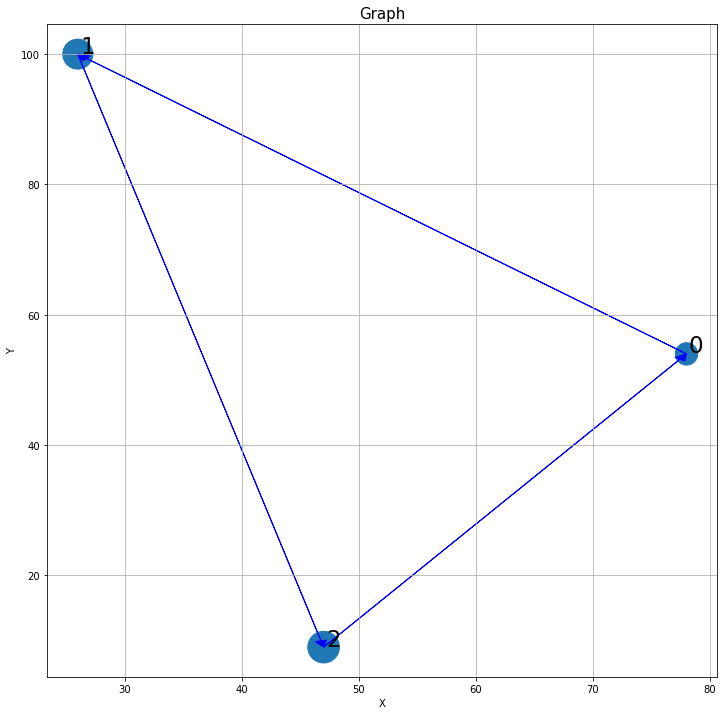

In [19]:
points, profits, costs = load_graph_csv(points_file="example_graph_points_profits.csv", arch_file="example_graph_arch_costs.csv")
plot_dgraph(points, profits, costs)

# Main Algorithm

### Handling Data

In [20]:
def random_points(n):
    points = {}
    for i in range(n):
        points[i] = (random.randint(0, 100), random.randint(0, 100))
    return(points)


def save_graph_csv(points, v_profits, a_costs, graphname="graph"):
    #saving points and profits
    df_points = pd.DataFrame.from_dict(
        points, orient='index', columns=["x_cor", "y_cor"])
    df_profits = pd.DataFrame.from_dict(
        v_profits, orient='index', columns=['vertex_profits'])
    df_vertexs = pd.concat([df_points, df_profits], axis=1)
    df_vertexs.to_csv(f"{graphname}_points_profits.csv", index=True)

    #saving arch costs
    df_costs = pd.DataFrame.from_dict(
        a_costs, orient='index', columns=["arch_costs"])
    df_costs.to_csv(f"{graphname}_arch_costs.csv", index=True)

    print("Saved the following data:\n")
    print(df_vertexs)
    print(df_costs)



def load_graph_csv(points_file="", arch_file=""):
    #read the csv files
    if not(len(points_file) > 0 and len(arch_file) > 0):
        print("need to specify filepaths")
        return None, None, None
    df_file_points = pd.read_csv(
        points_file, index_col=0)
    df_file_costs = pd.read_csv(arch_file, index_col=0)

    #create the vertex and vertex profit dictionaries
    loaded_points = df_file_points.to_dict(orient='index')
    points = {}
    profits = {}
    for i, _ in enumerate(loaded_points):
        points[i] = (loaded_points[i]["x_cor"], loaded_points[i]["y_cor"])
        profits[i] = (loaded_points[i]["vertex_profits"])

    loaded_costs = df_file_costs.to_dict()
    costs = {}
    for key, value in enumerate(loaded_costs["arch_costs"]):
        costs[tuple(eval(value))] = loaded_costs["arch_costs"][value]

    print("loaded the following data:\n")
    print(f"Points: {points}\nProfits: {profits}\nCosts: {costs}")

    return points, profits, costs


### Showing Data

### Initializing the Data

In [21]:
QUIET = 0
FILE_PATH_POINTS = "test_graph_points.csv"
FILE_PATH_COSTS = "test_graph_costs.csv"

N = 15
RANDOM = 0

loaded the following data:

Points: {0: (30, 20), 1: (60, 60), 2: (80, 60), 3: (70, 40), 4: (60, 30)}
Profits: {0: 50, 1: 50, 2: 1, 3: 1, 4: 2000}
Costs: {(0, 1): 1, (1, 2): 200, (1, 3): 1, (2, 3): 200, (3, 0): 1, (3, 4): 1, (4, 3): 1}
Initialized the following directed graph:
Points: {0: (30, 20), 1: (60, 60), 2: (80, 60), 3: (70, 40), 4: (60, 30)}
Points Profits: {0: 50, 1: 50, 2: 1, 3: 1, 4: 2000}
 Arch Costs: {(0, 1): 1, (1, 2): 200, (1, 3): 1, (2, 3): 200, (3, 0): 1, (3, 4): 1, (4, 3): 1}



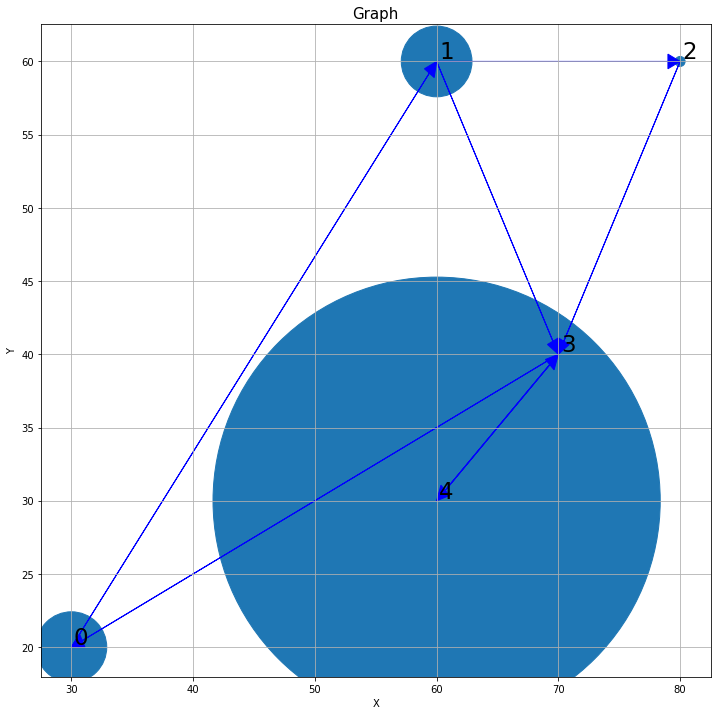

In [22]:
n = N

#creates a fully connected directed graph, with arches costs and vertex profits
if RANDOM > 0:
    random.seed(12345)
    points = random_points(n)
    arch_costs = {(i, j): random.randint(1, 10)
                  for i in range(n) for j in range(n) if i != j}
    vertex_profits = {i:
                      random.randint(1, 10)
                      for i in range(n)}
#else, loads a graph from two csv files with the specified FILE_PATH names
else:
    points, vertex_profits, arch_costs = load_graph_csv(
        points_file=FILE_PATH_POINTS, arch_file=FILE_PATH_COSTS)

#shows the graph data and plots it
print(
    f"Initialized the following directed graph:\nPoints: {points}\nPoints Profits: {vertex_profits}\n Arch Costs: {arch_costs}\n")
plot_dgraph(points, vertex_profits, arch_costs, show_vars=False)


if QUIET:
    gp.setParam('OutputFlag', 0)


Setting the Model Variables, Constraints and Objective Function

In [23]:
#CREATING THE MODEL
m = gp.Model("Mod_TSP")
m.reset()

# CREATING THE MODEL VARIABLES

#variables for vertex selection
Y_vertices = m.addVars(points.keys(),
                       vtype=GRB.BINARY, name='v')
print(f"Total vertices: {len(Y_vertices)}")

#variables for archs selection
X_archs = m.addVars(arch_costs.keys(),
                    vtype=GRB.BINARY, name='a')
print(f"Total arcs: {len(X_archs)}")

#CREATING THE MODEL CONSTRAINTS
#add vertex 0 (DEPOT VERTEX) constraint: the vertex 0 will always be selected
m.addConstr(Y_vertices[0] == 1, name="depot")

# Add degree-2 constraint only on selected vertices (we might not need an hamiltonian tour!)
m.addConstrs(X_archs.sum(i, '*') == Y_vertices[i]
             for i in Y_vertices.keys())
m.addConstrs(X_archs.sum('*', j) == Y_vertices[j]
             for j in Y_vertices.keys())


#CREATING THE MODEL OBJECTIVE FUNCTION
"""
We want to select a closed path so that the total profit, 
given by the total gain at the selected vertices minus the total cost 
of the selected archs, is as high as possible
"""
tot_gains = gp.quicksum(Y_vertices[i]*vertex_profits[i] for i in Y_vertices.keys())
tot_cost = gp.quicksum(X_archs[i, j]*arch_costs[i, j] for i, j in X_archs.keys())

m.setObjective(tot_gains - tot_cost, GRB.MAXIMIZE)

m.update()


Restricted license - for non-production use only - expires 2023-10-25
Discarded solution information
Total vertices: 5
Total arcs: 7


Using Lazy Constraints with Subtours Elimination to optimize

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11 rows, 12 columns and 25 nonzeros
Model fingerprint: 0x9cad02c2
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Selected Vertices to search for subtours: 3
List: [0, 1, 3]
Selected Arches to search for subtours:<gurobi.tuplelist (3 tuples, 2 values each):
 ( 0 , 1 )
 ( 1 , 3 )
 ( 3 , 0 )
> 
Found heuristic solution: objective 98.0000000
Presolve removed 11 rows and 11 columns
Presolve time: 0.00s
Presolved: 0 rows, 1 columns, 0 nonzeros
Variable types: 0 continuous, 1 integer (1 binary)

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 1: 98

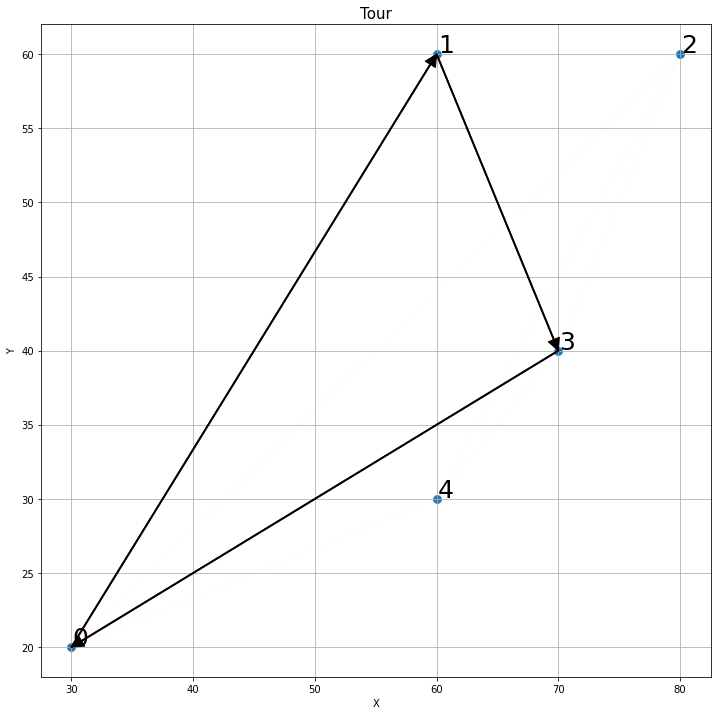

In [24]:
# Given the model, executes the subtour elimination of possible subtours of the given step solution
def subtourelim(model, where):

    if where == GRB.Callback.MIPSOL:
        # make a list of arches and vertices selected in the solution
        vals = model.cbGetSolution(model._vars)
        vertices = model.cbGetSolution(model._vars_vertices)

        num_selected_vert = len([vertices[i]
                                for i in vertices if vertices[i] > 0.5])
    
        sel_verts = gp.tuplelist(i for i in vertices.keys()
                                      if vertices[i] > 0.5)
        print(f"Selected Vertices to search for subtours: {num_selected_vert}\nList: {sel_verts}")
        
        selected_archs = gp.tuplelist((i, j) for i, j in vals.keys()
                                if vals[i, j] > 0.5)
        print(f"Selected Arches to search for subtours:{selected_archs} ")
        
        # find the shortest cycle in the selected arches list, given the selected vertices (lenght of path)
        tour = subtour(selected_archs, sel_verts, num_selected_vert)

        if len(tour) < num_selected_vert:
            #if there is a subtour, add the elimination constr. for every pair of cities in tour
            if not QUIET:
                print('\n>>> Subtour eliminated  %s\n' % str(tour))
            model.cbLazy(gp.quicksum(model._vars[i, j]
                                     for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Given a tuplelist of arches, find the shortest subtour
def subtour(arches,vertices, n):
    unvisited = list(vertices) #list of unvisited vertices
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in arches.select(current, '*')
                         if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle


m.Params.lazyConstraints = 1 #activating lazy constraints in the model
m._vars = X_archs
m._vars_vertices = Y_vertices
start = time.process_time() #start timer for computation time
m.optimize(subtourelim) #optimize using subtours eliminatio
end = time.process_time() #end time

var_x = m.getAttr('x', X_archs)
var_y = m.getAttr('x', Y_vertices)
sel_verts = gp.tuplelist(i for i in var_y.keys()
                         if var_y[i] > 0.5)
print(
    f"Selected Vertices for solution: {len(sel_verts)}\nList: {sel_verts}")

selected_archs = gp.tuplelist((i, j)
                        for i, j in var_x.keys() if var_x[i, j] > 0.5)

tour = subtour(selected_archs, sel_verts, len(sel_verts))
print('')
print("Points: ", points)
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g\n Time = %g' % (m.objVal, end-start))
print('')

sol_archs = {(i,j): arch_costs[i,j] for i,j in selected_archs}
print(f"solution archs dict: {sol_archs}")
sol_tour = {i: vertex_profits[i] for i in tour }
print(f"solution tour dict: {sol_tour}")
sol_points = {i: points[i] for i in tour}
print(f"solution points dict: {sol_points}")

#plot_dgraph(sol_points, sol_tour,sol_archs)
plot_tour(points, tour)



### Testing the algorithm with a cvs dataset

In [25]:
df_data = pd.read_csv("dataset_1.csv", index_col=0)
df_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Profits
0,NaN,NaN,NaN,70.0,NaN,NaN,NaN,62.0,3.0,42.0,62.0,7.0,NaN,13.0,NaN,0
1,98.0,NaN,86.0,29.0,NaN,NaN,12.0,NaN,34.0,NaN,NaN,NaN,32.0,NaN,18.0,6
2,NaN,29.0,NaN,NaN,89.0,NaN,48.0,78.0,NaN,NaN,NaN,86.0,62.0,91.0,87.0,92
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,44.0,NaN,NaN,16.0,47.0,NaN,NaN,70
4,53.0,47.0,58.0,15.0,NaN,NaN,73.0,28.0,35.0,89.0,NaN,37.0,14.0,NaN,59.0,90
5,NaN,44.0,62.0,NaN,NaN,NaN,NaN,34.0,97.0,89.0,4.0,NaN,45.0,NaN,NaN,47
6,70.0,NaN,NaN,22.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,81
7,NaN,NaN,65.0,19.0,NaN,33.0,NaN,NaN,59.0,NaN,70.0,20.0,NaN,NaN,NaN,11
8,NaN,NaN,17.0,NaN,50.0,NaN,87.0,86.0,NaN,61.0,NaN,NaN,NaN,11.0,NaN,65
9,56.0,NaN,71.0,NaN,NaN,7.0,NaN,NaN,98.0,NaN,NaN,77.0,NaN,19.0,NaN,74


In [26]:
profits = df_data['Profits'].to_dict()
df_data = df_data.fillna(0)
print(df_data)
print(profits)
print(len(df_data.columns))
print(len(df_data))
print(len(df_data.iloc[:,0:-1].columns))

arch_cost = {}
for i in range(len(df_data)):
    for j in range(len(df_data.iloc[:, 0:-1])):
        data = df_data.iloc[i, j]
        if data != 0:
            arch_cost[i,j] = df_data.iloc[i, j]



       0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   0.0   0.0  70.0   0.0   0.0   0.0  62.0   3.0  42.0   62.0   7.0   
1   98.0   0.0  86.0  29.0   0.0   0.0  12.0   0.0  34.0   0.0    0.0   0.0   
2    0.0  29.0   0.0   0.0  89.0   0.0  48.0  78.0   0.0   0.0    0.0  86.0   
3    0.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0  44.0   0.0    0.0  16.0   
4   53.0  47.0  58.0  15.0   0.0   0.0  73.0  28.0  35.0  89.0    0.0  37.0   
5    0.0  44.0  62.0   0.0   0.0   0.0   0.0  34.0  97.0  89.0    4.0   0.0   
6   70.0   0.0   0.0  22.0  48.0   0.0   0.0   0.0   0.0   0.0    0.0   0.0   
7    0.0   0.0  65.0  19.0   0.0  33.0   0.0   0.0  59.0   0.0   70.0  20.0   
8    0.0   0.0  17.0   0.0  50.0   0.0  87.0  86.0   0.0  61.0    0.0   0.0   
9   56.0   0.0  71.0   0.0   0.0   7.0   0.0   0.0  98.0   0.0    0.0  77.0   
10  55.0   6.0   2.0  21.0   0.0   0.0   0.0  27.0   3.0  92.0    0.0  49.0   
11  13.0   0.0   0.0  68.0   0.0  25.0   0.0  27.0  

In [27]:
points = random_points(len(df_data))
print(points)

{0: (0, 80), 1: (75, 17), 2: (37, 42), 3: (90, 70), 4: (72, 46), 5: (50, 57), 6: (11, 70), 7: (8, 19), 8: (39, 44), 9: (83, 32), 10: (39, 1), 11: (80, 100), 12: (58, 80), 13: (96, 62), 14: (19, 27)}


In [28]:
def load_graph_dataset(filename = ''):
    assert len(filename) > 0
    df_data = pd.read_csv(filename, index_col=0)
    df_data = df_data.fillna(0)
    profits = df_data['Profits'].to_dict()

    arch_cost = {}
    for i in range(len(df_data)):
        for j in range(len(df_data.iloc[:, 0:-1])):
            data = df_data.iloc[i, j]
            if data != 0:
                arch_cost[i, j] = df_data.iloc[i, j]
    
    points = random_points(len(df_data))

    return points, profits, arch_cost

Initialized the following directed graph:
Points: {0: (14, 76), 1: (59, 79), 2: (100, 12), 3: (82, 19), 4: (62, 5), 5: (45, 5), 6: (88, 100), 7: (20, 46), 8: (35, 82), 9: (81, 86), 10: (95, 73), 11: (17, 17), 12: (96, 59), 13: (38, 38), 14: (70, 75)}
Points Profits: {0: 0, 1: 6, 2: 92, 3: 70, 4: 90, 5: 47, 6: 81, 7: 11, 8: 65, 9: 74, 10: 38, 11: 63, 12: 70, 13: 85, 14: 61}
 Arch Costs: {(0, 3): 70.0, (0, 7): 62.0, (0, 8): 3.0, (0, 9): 42.0, (0, 10): 62.0, (0, 11): 7.0, (0, 13): 13.0, (1, 0): 98.0, (1, 2): 86.0, (1, 3): 29.0, (1, 6): 12.0, (1, 8): 34.0, (1, 12): 32.0, (1, 14): 18.0, (2, 1): 29.0, (2, 4): 89.0, (2, 6): 48.0, (2, 7): 78.0, (2, 11): 86.0, (2, 12): 62.0, (2, 13): 91.0, (2, 14): 87.0, (3, 7): 20.0, (3, 8): 44.0, (3, 11): 16.0, (3, 12): 47.0, (4, 0): 53.0, (4, 1): 47.0, (4, 2): 58.0, (4, 3): 15.0, (4, 6): 73.0, (4, 7): 28.0, (4, 8): 35.0, (4, 9): 89.0, (4, 11): 37.0, (4, 12): 14.0, (4, 14): 59.0, (5, 1): 44.0, (5, 2): 62.0, (5, 7): 34.0, (5, 8): 97.0, (5, 9): 89.0, (5, 10): 4

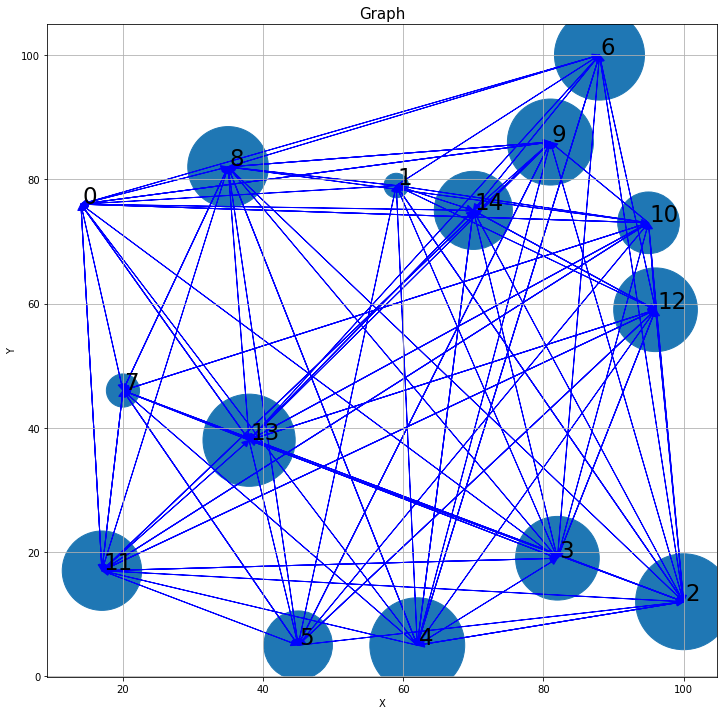

Discarded solution information
Total vertices: 15
Total arcs: 105
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 31 rows, 120 columns and 241 nonzeros
Model fingerprint: 0x6d1cdd2b
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Selected Vertices to search for subtours: 3
List: [0, 6, 13]
Selected Arches to search for subtours:<gurobi.tuplelist (3 tuples, 2 values each):
 ( 0  , 13 )
 ( 6  , 0  )
 ( 13 , 6  )
> 
Found heuristic solution: objective 3.0000000
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 30 rows, 119 columns, 238 nonzeros
Variable types: 0 continuous, 119 integer (119 binary)

Root relaxation: objective 5.500000e+02, 25 iterations, 0.00 

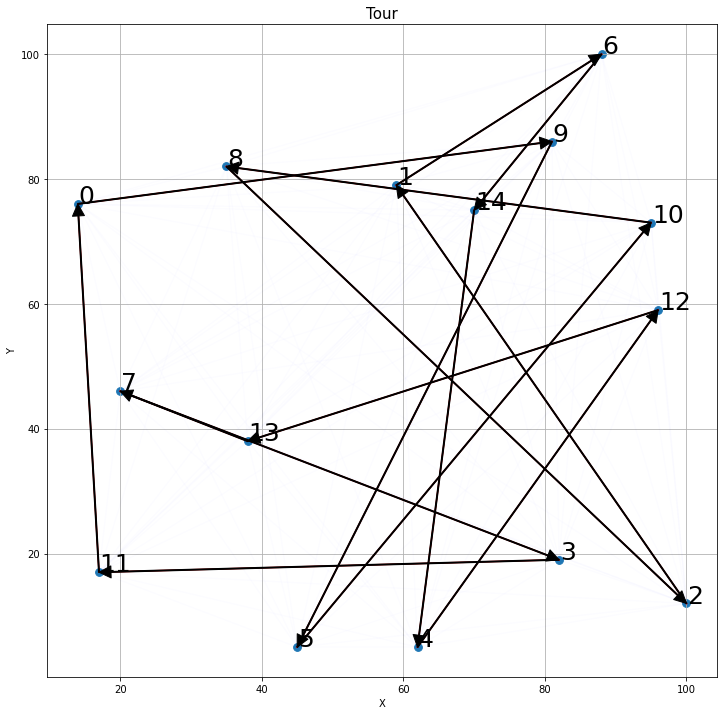

In [29]:
n = N

# creates a fully connected directed graph, with arches costs and vertex profits
if RANDOM > 0:
    random.seed(12345)
    points = random_points(n)
    arch_costs = {(i, j): random.randint(1, 10)
                    for i in range(n) for j in range(n) if i != j}
    vertex_profits = {i:
                        random.randint(1, 10)
                        for i in range(n)}
# else, loads a graph from two csv files with the specified FILE_PATH names
else:
    points, vertex_profits, arch_costs = load_graph_dataset(filename= "dataset_1.csv" )

# shows the graph data and plots it
print(
    f"Initialized the following directed graph:\nPoints: {points}\nPoints Profits: {vertex_profits}\n Arch Costs: {arch_costs}\n")
plot_dgraph(points, vertex_profits, arch_costs, show_vars=False)

if QUIET:
    gp.setParam('OutputFlag', 0)

# CREATING THE MODEL
m = gp.Model("Mod_TSP")
m.reset()

# CREATING THE MODEL VARIABLES

# variables for vertex selection
Y_vertices = m.addVars(points.keys(),
                        vtype=GRB.BINARY, name='v')
print(f"Total vertices: {len(Y_vertices)}")

# variables for archs selection
X_archs = m.addVars(arch_costs.keys(),
                    vtype=GRB.BINARY, name='a')
print(f"Total arcs: {len(X_archs)}")

# CREATING THE MODEL CONSTRAINTS
# add vertex 0 (DEPOT VERTEX) constraint: the vertex 0 will always be selected
m.addConstr(Y_vertices[0] == 1, name="depot")

# Add degree-2 constraint only on selected vertices (we might not need an hamiltonian tour!)
m.addConstrs(X_archs.sum(i, '*') == Y_vertices[i]
                for i in Y_vertices.keys())
m.addConstrs(X_archs.sum('*', j) == Y_vertices[j]
                for j in Y_vertices.keys())

# CREATING THE MODEL OBJECTIVE FUNCTION
"""
We want to select a closed path so that the total profit, 
given by the total gain at the selected vertices minus the total cost 
of the selected archs, is as high as possible
"""
tot_gains = gp.quicksum(Y_vertices[i]*vertex_profits[i]
                        for i in Y_vertices.keys())
tot_cost = gp.quicksum(X_archs[i, j]*arch_costs[i, j]
                        for i, j in X_archs.keys())

m.setObjective(tot_gains - tot_cost, GRB.MAXIMIZE)

m.update()

m.Params.lazyConstraints = 1  # activating lazy constraints in the model
m._vars = X_archs
m._vars_vertices = Y_vertices
start = time.process_time()  # start timer for computation time
m.optimize(subtourelim)  # optimize using subtours eliminatio
end = time.process_time()  # end time

var_x = m.getAttr('x', X_archs)
var_y = m.getAttr('x', Y_vertices)
sel_verts = gp.tuplelist(i for i in var_y.keys()
                            if var_y[i] > 0.5)

selected_archs = gp.tuplelist((i, j)
                                for i, j in var_x.keys() if var_x[i, j] > 0.5)

tour = subtour(selected_archs, sel_verts, len(sel_verts))
print('')
print("Points: ", points)
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g\n Time = %g' % (m.objVal, end-start))
print('')

sol_archs = {(i, j): arch_costs[i, j] for i, j in selected_archs}
print(f"solution archs dict: {sol_archs}")
sol_tour = {i: vertex_profits[i] for i in tour}
print(f"solution tour dict: {sol_tour}")
sol_points = {i: points[i] for i in tour}
print(f"solution points dict: {sol_points}")

#plot_dgraph(sol_points, sol_tour,sol_archs)
plot_tour(points, tour)
